In [8]:
import matplotlib.pyplot as plt
import numpy as np

#superpixels
from sklearn.cluster import MiniBatchKMeans
from skimage.segmentation import slic, mark_boundaries
from skimage import measure
import cv2
import groupXY_functions as util

image = "ISIC_0003462"
im = plt.imread(f'data/red25/{image}.jpg')
#mask=plt.imread('data/example_segmentation/ISIC_0012206_segmentation.png')

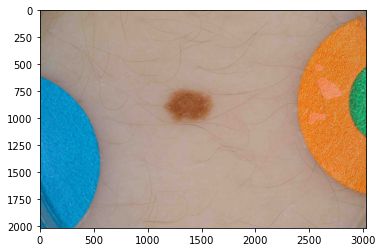

In [2]:
plt.imshow(im)

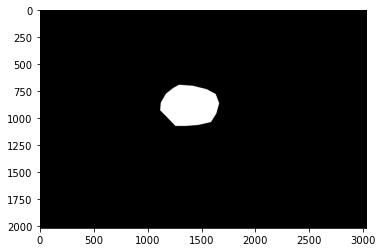

In [3]:
#See the mask

mask=plt.imread(f'data/example_segmentation/{image}_segmentation.png')
plt.imshow(mask, cmap='gray')

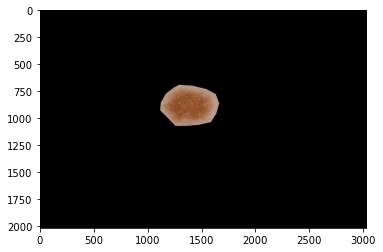

In [4]:
# Replace the non-lesion pixels

img1 = im.copy()
img1[mask==0] = 0 #if the mask is black at some spot, set image color to black at that spot
  
# Display 
plt.imshow(img1)

# You can use any package you prefer, but beware you might need to convert between formats

In [9]:
a,b,c,d = util.extract_bboxes(np.array(img1))
img1 = img1[a:b,c:d]

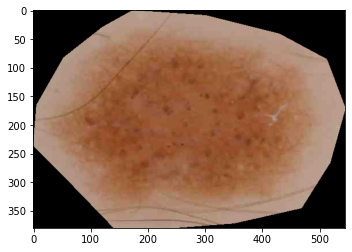

In [10]:
plt.imshow(img1)

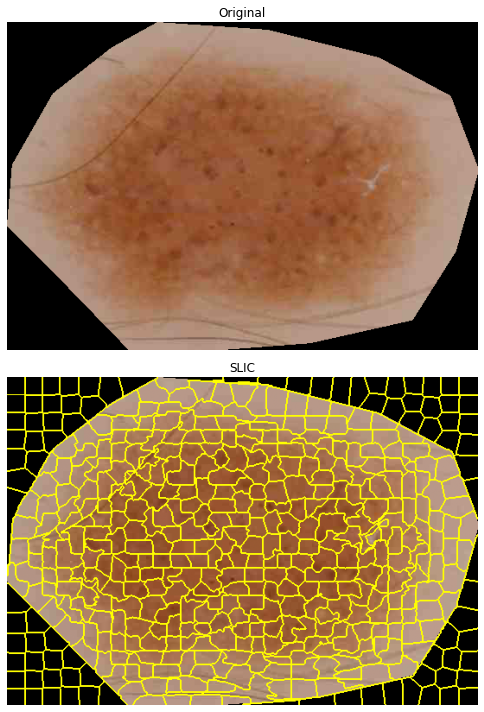

In [11]:
# Divide the pixels into segments (segment = piece of continuous color in the image)
segments_slic = slic(img1, n_segments=500, compactness=5, sigma=1, start_label=0, enforce_connectivity = True)
#compactness - how much x,y values count
#sigma - smoothness of the lines

fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True, sharey=True)

ax[0].imshow(img1)
ax[0].set_title("Original")
ax[1].imshow(mark_boundaries(img1, segments_slic)) #mark boundaries shows boundaries on the image
ax[1].set_title('SLIC')

ax.ravel()

for a in ax.ravel(): #ravel flattens the ax array, allowing for iterating to turn off axis
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [6]:
#Getting the mean RGB values for selected slic parts

qualities = measure.regionprops(segments_slic, intensity_image=img1)

#print([region.max_intensity for region in qualities])
#print([region.intensity_min for region in qualities])

#get RGB mean intensity value for each segment and change them to ints for clarity
rgb_mean_all = np.array([region.mean_intensity for region in qualities]).astype(int) 

#delete all rows encoding black parts. Sometimes 1 or 2 pops out on the border so the threshold has to be a bit higher, let's say 5
rgb_mean = rgb_mean_all[~np.all(rgb_mean_all < 5, axis=1)] 

rgb_mean.shape #43 RGB values
#print(qualities[1].max_intensity)


(12, 3)

In [7]:
#Conversion to gray for overall color intensity comparison

def rgb2gray(rgb_mean):

    r, g, b = rgb_mean[:,0], rgb_mean[:,1], rgb_mean[:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray #RGB taken down to one numerical value

gray = rgb2gray(rgb_mean) #conversion to gray

gray.shape #43 gray values, double-checking

color_variance = np.max(gray) - np.min(gray)
print(color_variance) #number describing the spread between overall color intensity

59.48049999999998


In [9]:
#LIMITATIONS

#The excerpt still has a part of skin, which is compared to other parts of the lesion. We should probably get rid of it entirely
#this is not acceptable

#The solution uses the gray scale, so it doesn't show all the nuances of RGB. On the other hand, I think we can't describe the color variance
#with one number accounting for 3 colors channels at the same time - this is acceptable

#Idea about the color - identify a leading color for each superpixel, see if the colors different inside the lesion. 
#This is very prone to threshold

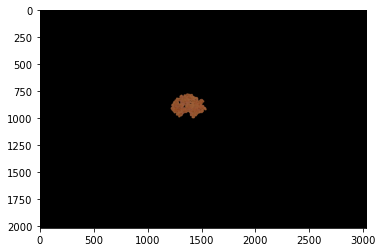